In [1]:
import numpy as np
import scipy.stats as sc
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import OOQueueLib_modHW6 as ooQ

In [66]:
#code based off of hospital queuing system for ORIE 4580
def runSystem(numCAPSCounselors, capGroupCounseling, numPrimaryCare, numBehavioralHealth, t_end):
    
    #Arrival rates, assuming distributed evenly over semester, per hour
    percentStudents = .84 #based on 42% of students in 2019 unable to function academically
    totalStudents = 15000
    arrivalRate = percentStudents*totalStudents/(742)  #number of business hours during semester

    #service rates per hour
    mu_CAPS = 1/(25/60)
    mu_groupCounseling = 1/(90/60)
    mu_primaryCare = 1/(25/60)
    mu_behavioralHealth = 1/(25/60)
    mu_twoWeekFollowUp = 1/(53*2) #waiting time in business hours
    mu_oneWeekFollowUp = 1/(53)
    #mu_behavioralHealthReferral = 1/2

    #create a queue for each stage of care
    CAPS = ooQ.Queue("CAPS", numCAPSCounselors, mu_CAPS, 0, [], [])
    groupCounseling = ooQ.Queue("Group", capGroupCounseling, mu_groupCounseling, 0, [], [])
    primaryCare = ooQ.Queue("Primary Care", numPrimaryCare, mu_primaryCare, 0, [], [])
    behavioralHealth = ooQ.Queue("Behavioral Health", numBehavioralHealth, mu_behavioralHealth, 0, [], [])
    twoWeekFollowUp = ooQ.Queue("two weeks", 1e6, mu_twoWeekFollowUp, 0, [],[])
    oneWeekFollowUp = ooQ.Queue("one week", 1e6, mu_oneWeekFollowUp, 0, [],[])
    #behavioralHealthReferral = ooQ.Queue("referral", 1e6, mu_behavioralHealthReferral, 0, [],[])
    listOfStages = [CAPS, groupCounseling, primaryCare, behavioralHealth, 
                   twoWeekFollowUp, oneWeekFollowUp]
    
    #probabilities if multiple options
    p_arrivaltoCAPS = 0.8*.8 #.50, .40
    p_arrivaltoGroup = 0.1*.8 #.25, .40
    p_arrivaltoPrimary = 0.1*.8 #.25, .20
    #p_arrivaltoNoHelp = 1-0.42
    
    p_CAPStoCAPS = 0.75 #two week delay
    p_CAPStoGroup = 0.05 #one week delay
    p_CAPStoOut = 0.20
    
    p_GrouptoGroup = 0.75 #one week delay
    p_GrouptoOut = 0.25
    
    p_PrimarytoCaps = 0.25 
    p_PrimarytoGroup = 0.25
    p_PrimarytoBehavioral = 0.40 
    p_PrimarytoOut = 0.10
    
    #p_BehavorialtoBehavioral = 0.5
    #p_BehavioraltoOut = 0.5
    
    t = 0
    
    #generate events
    eventRates = np.array([arrivalRate] + [stg.serviceRate*stg.serversOn for stg in listOfStages])
    totalRate = sum(eventRates)
    cumsumRate = np.cumsum(eventRates/totalRate)#cdf of event probabilities
    nextEventTime = t+np.random.exponential(1/totalRate)
    
    #track times
    times = []
    
    while t < t_end:
        
        #jump to next event
        t = nextEventTime
        U = np.random.rand()
        event = np.where((cumsumRate >= U))[0][0] #gives index for event
        #print(event)
        #do events corresponding to what the nearest next time is
        if event == 0: #arrival
            #print("student develops a mental health issue,")
            student = ooQ.Entity(t)
            nextStep = np.random.rand()
            
            if nextStep <= p_arrivaltoCAPS:
                #print("chooses CAPS")
                CAPS.ArriveatQueue(student, t)
                if CAPS.serversOn < CAPS.capacity:
                    CAPS.startService(t)
            elif nextStep <= p_arrivaltoGroup + p_arrivaltoCAPS:
                #print("chooses Group therapy")
                groupCounseling.ArriveatQueue(student, t)
                if groupCounseling.serversOn < groupCounseling.capacity:
                    groupCounseling.startService(t)
            elif nextStep <= p_arrivaltoPrimary + p_arrivaltoGroup + p_arrivaltoCAPS:
                #print("chooses Primary Care")
                primaryCare.ArriveatQueue(student, t)
                if primaryCare.serversOn < primaryCare.capacity:
                    primaryCare.startService(t)
            #elif nextStep <= 1: #doesn't seek help, don't need to do anything to system
               # print("doesn't seek help")
            
        elif event == 1: #CAPS finish
            if CAPS.serversOn > 0:
                #print("a student finished CAPS session,")
    
                student = CAPS.endService(t)
                nextStep = np.random.rand()
            
                if nextStep <= p_CAPStoCAPS:
                    #print("schedules another session")
                    twoWeekFollowUp.ArriveatQueue(student, t)
                    twoWeekFollowUp.startService(t)
                elif nextStep <= p_CAPStoGroup+p_CAPStoCAPS:
                    #print("referred to group therapy")
                    oneWeekFollowUp.ArriveatQueue(student, t)
                    oneWeekFollowUp.startService(t)
                
                if np.size(CAPS.waitingentities) > 0:
                    CAPS.startService(t)
            
        elif event == 2: #Group finish
            if groupCounseling.serversOn > 0:
                #print("a student finished a Group session, ")
                #print(groupCounseling.serversOn)
                nextStep = np.random.rand()
                student = groupCounseling.endService(t)
            
            
                if nextStep <= p_GrouptoGroup:
                    #print("schedules one for next week")
                    oneWeekFollowUp.ArriveatQueue(student, t)
                    oneWeekFollowUp.startService(t)
                #elif nextStep <= 1:
                    #print("leaves Cornell system")
            
                if np.size(groupCounseling.waitingentities) > 0:
                    groupCounseling.startService(t)
                
        elif event == 3: #Primary care finish
            #print("a student finished a doctor's visit, ")
            student = primaryCare.endService(t)
            nextStep = np.random.rand()
            
            if nextStep <= p_PrimarytoCaps:
                #print("schedules a CAPS session")
                CAPS.ArriveatQueue(student, t)
                if CAPS.serversOn < CAPS.capacity:
                    CAPS.startService(t)
            elif nextStep <= p_PrimarytoGroup:
                #print("schedules a group therapy session")
                groupCounseling.ArriveatQueue(student, t)
                if groupCounseling.serversOn < groupCounseling.capacity:
                    groupCounseling.startService(t)
            elif nextStep <= p_PrimarytoBehavioral:
                #print("is referred to behavioral health")
                behavioralHealth.ArriveatQueue(student, t)
                if behavioralHealth.serversOn < behavioralHealth.capacity:
                    behavioralHealth.startService(t)
            #else:
                #print("leaves Cornell's system")
                
            if np.size(primaryCare.waitingentities) > 0:
                primaryCare.startService(t)
                
        elif event == 4: #Behavioral finish
            if behavioralHealth.serversOn > 0 and behavioralHealth.capacity > 0:
                #print("a student finished a behavioral health consultation")
                student = behavioralHealth.endService(t)
            
                if np.size(behavioralHealth.waitingentities)> 0:
                    behavioralHealth.startService(t)
            
        elif event == 5: #two week finish
            if twoWeekFollowUp.serversOn >0:
                #print("a student has a follow up CAPS session")
                student  = twoWeekFollowUp.endService(t)
                CAPS.ArriveatQueue(student, t)
                if CAPS.serversOn < CAPS.capacity:
                    CAPS.startService(t)
        else: #one week finish
            if oneWeekFollowUp.serversOn>0:
                #print("a student has a follow up group therapy session")
                student = oneWeekFollowUp.endService(t)
                groupCounseling.ArriveatQueue(student, t)
                if groupCounseling.serversOn < groupCounseling.capacity:
                    groupCounseling.startService(t)

        
        #update records
        times.append(t)
        for stg in listOfStages:
            stg.queueLength.append(np.size(stg.waitingentities))
            stg.busy.append(stg.serversOn)
            
        #time for next event
        eventRates = np.array([arrivalRate]+[stg.serviceRate*stg.serversOn for stg in listOfStages])
        totalRate = sum(eventRates)
        cumsumRate = np.cumsum(eventRates/totalRate)
        nextEventTime = t + np.random.exponential(1/totalRate)
        
    return times, listOfStages

In [67]:
def plot_queues(times, listOfStages):
    fig_size = [6,4]
    plt.rcParams["figure.figsize"] = fig_size

    for stg in listOfStages[0:5]:
        plt.plot(times, stg.queueLength)
        plt.axis((None, None, 0, None))
        plt.title('Queue Lengths of '+ stg.name)
        plt.ylabel('students waiting')
        plt.xlabel('Time')
        
        
        plt.show()

In [143]:
#run with 2019 actual staffing
numCAPSCounselors = 20
capGroupCounseling = 50
numPrimaryCare = 5 #assumed number due to not being able to build full cornell health model
numBehavioralHealth = 2
t_end = 742 #number of business hours over semester

time_store = []
queue_store = []
for i in range(100):
    times, listOfStages = runSystem(numCAPSCounselors, capGroupCounseling, numPrimaryCare, numBehavioralHealth, t_end)
    queue_store.append(listOfStages[0])
    time_store.append(times)


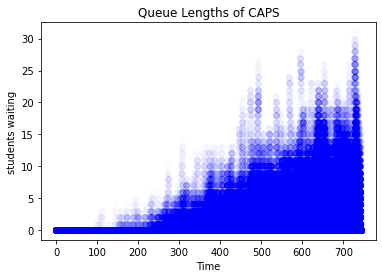

In [138]:
fig_size = [6,4]
plt.rcParams["figure.figsize"] = fig_size

for i in range(100):
    plt.plot(time_store[i], queue_store[i].queueLength, '-ok', c="blue", alpha=0.01)

plt.title("Queue Lengths of CAPS")
plt.ylabel('students waiting')
plt.xlabel('Time')

plt.show()

In [144]:
maxes = []
for i in queue_store:
    maxes.append(sum(i.queueLength)/len(i.queueLength))
sum(maxes)/len(maxes)

0.3532893132109329

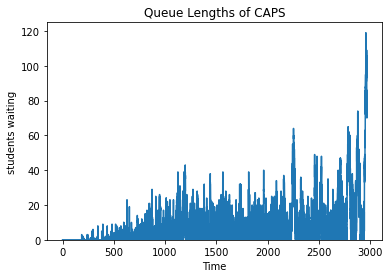

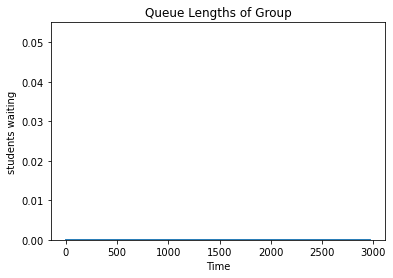

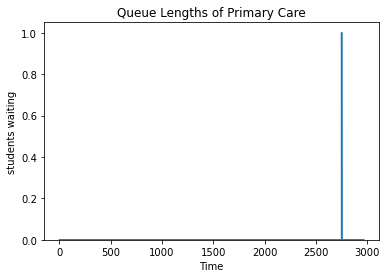

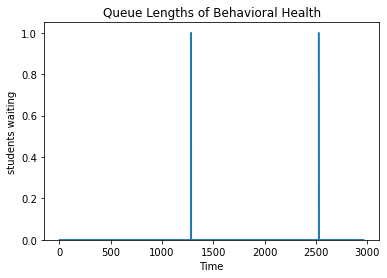

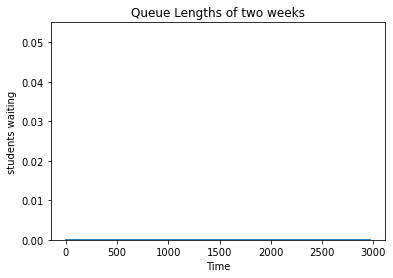

In [136]:
plot_queues(times, listOfStages)